# Robustness Experiments
This notebook reproduces the epsilon-robustness experiments found in the paper "Towards Robust Classification with Deep Generative Forests".

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, balanced_accuracy_score, f1_score

from gefs import PC, RandomForest, compute_rob_class
from prep import get_dummies, get_data, get_stats, train_test_split, standardize_data, normalize_data

## Relationship Between Accuracy and Robustness

In [2]:
d_rob, d_pred, d_true = {}, {}, {}
datasets = ['diabetes', 'cmc', 'texture', 'german', 'electricity', 'dna', 
            'bank', 'gesture', 'jungle', 'vowel', 'mice', 'phishing']

# For each dataset
for name in datasets:
    print(name)
    data, ncat = get_data(name)  # Preprocess the data
    X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(data, ncat)
    rf = RandomForest(n_estimators=30, ncat=ncat)  # Train a Random Forest
    rf.fit(X_train, y_train)
    gef = rf.topc()  # Convert to a GeF
    # Predict and compute the robustness of each test sample and save to a dictionary
    pred, rob = compute_rob_class(gef.root, X_test, data.shape[1]-1, int(ncat[-1]))
    d_rob[name] = rob
    d_pred[name] = pred
    d_true[name] = y_test

diabetes


  0%|          | 0/30 [00:00<?, ?it/s]

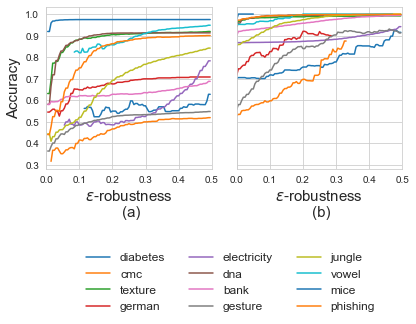

In [3]:
fig, axs = plt.subplots(1, 2, sharey=True, sharex=False)
fig.set_size_inches(w=5.5, h=2.5)
plt.set_cmap('tab20')

for name in datasets:
    rob = d_rob[name]
    pred = d_pred[name]
    y_test = d_true[name]
    # Arange the edges from 0 to 0.5
    # 0.5 is the maximum robustness value for this particular type of GeF, as a perturbation larger than 0.5  
    # necessarily changes the most likely class in the multinomial distribution of the final leaf.
    edges = np.arange(0, 0.5, 0.005)

    acc = []
    es = []
    for e in edges:
        preds = pred[rob <= e]
        trues = y_test[rob <= e]
        if preds.shape[0] >= 30:  # Consider only statistics for more than 30 points
            acc.append(accuracy_score(trues, preds))
            es.append(e)
    axs[0].plot(es, acc, '-', label=name)
    axs[0].set_xlim(0, 0.2)
    axs[0].set_xlabel('$\epsilon$-robustness \n (a)', fontsize=15)
    axs[0].set_ylabel('Accuracy', fontsize=15)
    axs[0].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])

    acc = []
    es = []
    for e in edges:
        preds = pred[rob >= e]
        trues = y_test[rob >= e]
        if preds.shape[0] >= 30:  # Consider only statistics for more than 30 points
            acc.append(accuracy_score(trues, preds))
            es.append(e)
    axs[1].plot(es, acc, '-', label=name)
    axs[1].set_xlim(0, 0.2)
    axs[1].set_xlabel('$\epsilon$-robustness \n (b)', fontsize=15)
    axs[1].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])

plt.legend(bbox_to_anchor=(0.9, -.45), ncol=3, frameon=False, fontsize=12)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=.35, wspace=.15)
sns.set_style("whitegrid")

## Mnist Experiments

In [4]:
# Preprocess the data
data, ncat = get_data('mnist')  # 'fashion' for Fashion-Mnist data
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(data, ncat, prep=None)
# Train a Random Forest
rf = RandomForest(n_estimators=30, ncat=ncat, min_samples_leaf=1)
rf.fit(X_train, y_train)
gef = rf.topc()  # Convert to GeF

100%|██████████| 30/30 [00:03<00:00,  7.89it/s]


In [5]:
# Compute the robustness of each instance
pred, rob = np.array([]), np.array([])
# Computing the robustness of each and every image takes some time.
# We run it in batches so we can monitor the progress and stop at any time.
for i in range(210):
    print(i, end = ' ')
    pred_i, rob_i = compute_rob_class(gef.root, X_test[i*100:(i+1)*100, :], data.shape[1]-1, int(ncat[-1]))
    pred = np.concatenate((pred, pred_i))
    rob = np.concatenate((rob, rob_i))

0 1 2 3 4 5 6 7 8 9 

### Order the images according to their robustness value.

In [6]:
maxis = np.argsort(rob*(-1))
minis = np.argsort(rob)

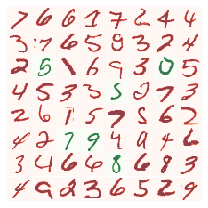

In [7]:
# LEAST ROBUST
# settings
h, w = 10, 10        # for raster image
nrows, ncols = 8, 8  # array of sub-plots
figsize = [3, 3]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
         'GnBu', 'RdPu', 'Greys', 'BuGn', 'coolwarm']

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
        'spring', 'summer', 'autumn', 'winter', 'cool']

for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    idx = minis[i]
    img = X_test[idx, :].reshape(28, 28).copy()/255
    alpha = 0.75
    if y_test[idx] != pred[idx]:
        cmap = 'Reds'
    else:
        cmap = 'Greens'
    axi.imshow(img, alpha=alpha, cmap=cmap, vmin=0, vmax=1)
    axi.axis('off')

plt.tight_layout(True)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=.0, wspace=.0)
plt.show()

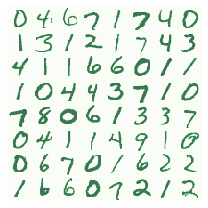

In [8]:
# MOST ROBUST
# settings
h, w = 10, 10        # for raster image
nrows, ncols = 8, 8  # array of sub-plots
figsize = [3, 3]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
         'GnBu', 'RdPu', 'Greys', 'BuGn', 'coolwarm']

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
        'spring', 'summer', 'autumn', 'winter', 'cool']

for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    idx = maxis[i]
    img = X_test[idx, :].reshape(28, 28).copy()/255
    alpha = 0.75
    if y_test[idx] != pred[idx]:
        cmap = 'Reds'
    else:
        cmap = 'Greens'
    axi.imshow(img, alpha=alpha, cmap=cmap, vmin=0, vmax=1)
    axi.axis('off')

plt.tight_layout(True)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=.0, wspace=.0)
plt.show()

### Order the image according to their likelihood

In [9]:
data_logs = data_test[:, :].copy()
data_logs[:, -1] = np.nan
logs = gef.log_likelihood(data_logs)
log_max = np.argsort(logs*(-1))
log_min = np.argsort(logs)

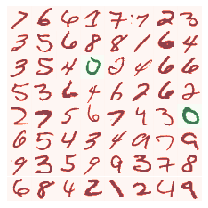

In [10]:
# MOST LIKELY
# settings
h, w = 10, 10        # for raster image
nrows, ncols = 8, 8  # array of sub-plots
figsize = [3, 3]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
         'GnBu', 'RdPu', 'Greys', 'BuGn', 'coolwarm']

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
        'spring', 'summer', 'autumn', 'winter', 'cool']

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    idx = log_min[i]
    img = X_test[idx, :].reshape(28, 28).copy()/255
    alpha = 0.75
    if y_test[idx] != pred[idx]:
        cmap = 'Reds'
    else:
        cmap = 'Greens'
    img = np.where(img < 0.1, rob[idx], img)
    axi.imshow(img, alpha=alpha, cmap=cmap, vmin=0, vmax=1)
    axi.axis('off')

plt.tight_layout(True)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=.0, wspace=.0)
plt.show()

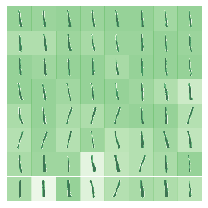

In [11]:
# LEAST LIKELY
# settings
h, w = 10, 10        # for raster image
nrows, ncols = 8, 8  # array of sub-plots
figsize = [3, 3]     # figure size, inches

# create figure (fig), and array of axes (ax)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
         'GnBu', 'RdPu', 'Greys', 'BuGn', 'coolwarm']

cmaps = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 
        'spring', 'summer', 'autumn', 'winter', 'cool']

# plot simple raster image on each sub-plot
for i, axi in enumerate(ax.flat):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    idx = log_max[i]
    img = X_test[idx, :].reshape(28, 28).copy()/255
    alpha = 0.75
    if y_test[idx] != pred[idx]:
        cmap = 'Reds'
    else:
        cmap = 'Greens'
    img = np.where(img < 0.1, rob[idx], img)
    axi.imshow(img, alpha=alpha, cmap=cmap, vmin=0, vmax=1)
    axi.axis('off')

plt.tight_layout(True)
plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=.0, wspace=.0)
plt.show()